In [1]:
import warnings
warnings.filterwarnings('ignore')


import anndata as ad
import squidpy as sq
import scanpy as sc

import numpy as np
import pandas as pd
import os

import re
import json

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from cycler import cycler

In [57]:
# --------------------------------------------------------------------------------
# Edit this path
# --------------------------------------------------------------------------------
FILEPATHBASE = '/Users/mmd47/Library/CloudStorage/GoogleDrive-mmd47@yale.edu/My Drive/DiStasio Lab/DiStasio Lab Share/'
#FILEPATHBASE = '/home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/'


# --------------------------------------------------------------------------------
SAVEFIGS = True
if SAVEFIGS:
    IMGDIR = os.path.join(FILEPATHBASE, '02 Analysis','Muscle_IBM', 'Output')

In [3]:
# --------------------------------------------------------------------------------
# Load datasets 
# --------------------------------------------------------------------------------
filename = os.path.join(FILEPATHBASE,
                        '03 Data/Muscle_IBM_-_Bhaskar/DM IBM 1/IBM_Muscle_1_Curio_OUTPUT/OUTPUT/IBM_MuscleBx_1',
                        'IBM_MuscleBx_1_anndata_annotated.h5ad')
                        
print("Loading Data from: " + filename)
muscle = ad.read_h5ad(filename)


Loading Data from: /Users/mmd47/Library/CloudStorage/GoogleDrive-mmd47@yale.edu/My Drive/DiStasio Lab/DiStasio Lab Share/03 Data/Muscle_IBM_-_Bhaskar/DM IBM 1/IBM_Muscle_1_Curio_OUTPUT/OUTPUT/IBM_MuscleBx_1/IBM_MuscleBx_1_anndata_annotated.h5ad


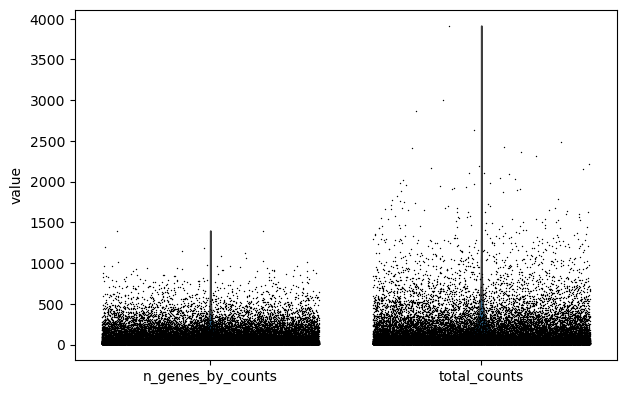

In [14]:
#Useful link: 
# https://support.parsebiosciences.com/hc/en-us/articles/360052794312-Scanpy-Tutorial-65k-PBMCs

sc.pp.calculate_qc_metrics(
    muscle,  percent_top=None, log1p=False, inplace=True
)
sc.pl.violin(
    muscle,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=False
)

In [15]:
sc.pp.regress_out(muscle, ['total_counts'])

In [16]:
myofiber = muscle[muscle.obs['Myofiber'],:]
endomysium = muscle[muscle.obs['Endomysium'],:]
immune = muscle[muscle.obs['Immune cells'],:]


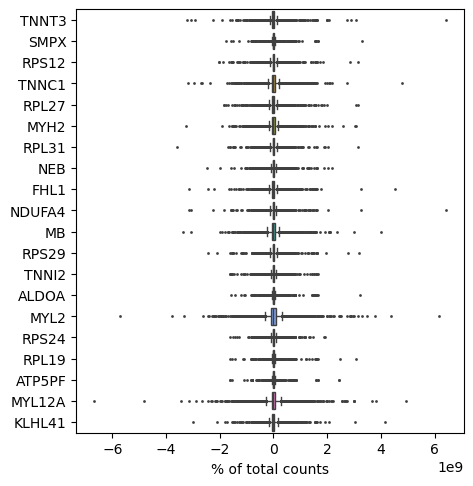

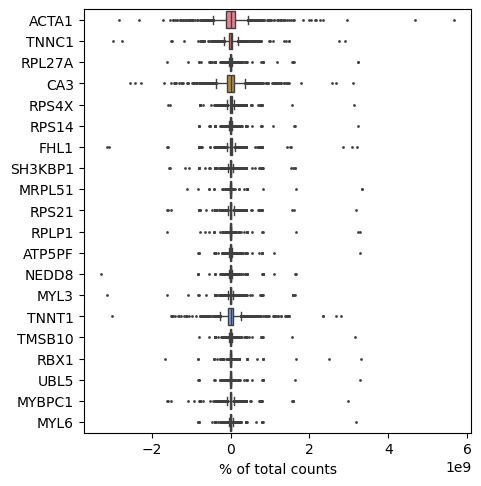

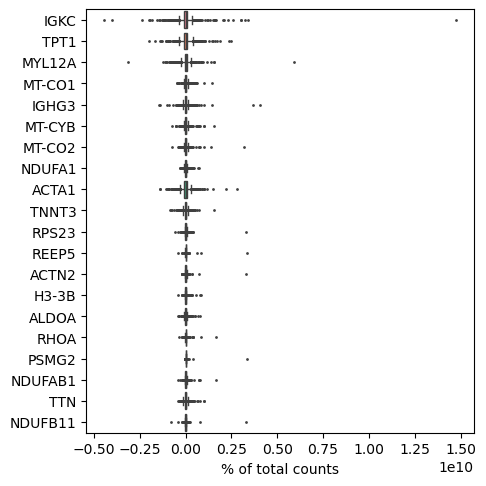

In [17]:
sc.pl.highest_expr_genes(myofiber, n_top=20)
sc.pl.highest_expr_genes(endomysium, n_top=20)
sc.pl.highest_expr_genes(immune, n_top=20)

         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


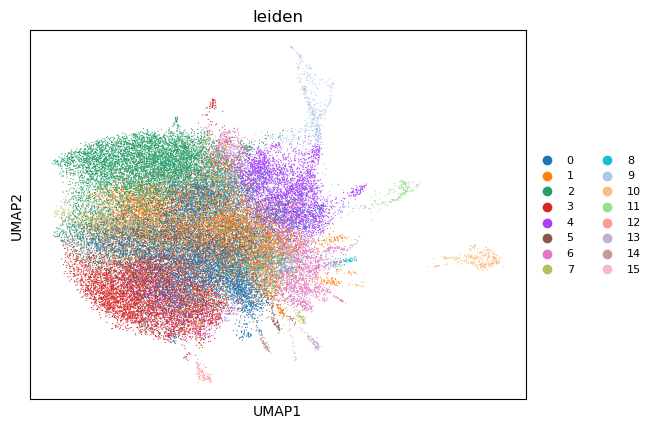

In [19]:
sc.pp.neighbors(muscle, n_neighbors=10, n_pcs=30)
sc.tl.umap(muscle)
sc.tl.leiden(muscle, resolution=0.5)
sc.pl.umap(muscle, color=['leiden'], legend_fontsize=8, save='_leiden')

In [22]:


#### Marker genes

sc.tl.rank_genes_groups(muscle, 'leiden', method='t-test')
sc.pl.rank_genes_groups(muscle, n_genes=10, sharey=False)




KeyboardInterrupt: 

In [ ]:
# Merging cell clusters (IF NECESSARY)

# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = {'CD4 T': ['3','4','6','9','10','12'], 'CD14+ Mono': ['8'], 'B': ['1','7','11'], 'CD8 T': ['2'],
    'FCGR3A+ Mono': ['5'], 'NK': ['0','14','17','18'], 'DC': ['13','16'], 'IGHA+': ['15'], 'ZNF385D+': ['19']}

# Initialize empty column in cell metadata
adata.obs['merged'] = np.nan

# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'merged'] = i

sc.pl.umap(adata, color=['merged'], legend_loc='on data', legend_fontsize=6, save='_merged_new_lbl')

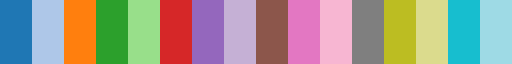

In [50]:
GroupsToAnalyze = list(np.arange(0,len(np.unique(muscle.obs['leiden']))))
groups = [sorted(np.unique(muscle.obs['leiden']), key=lambda x: int(x))[i] for i in GroupsToAnalyze]
nGroupsToPlot = len(GroupsToAnalyze)

muscle.obs['leiden_sel'] = muscle.obs['leiden']
muscle.obs['leiden_sel'] = muscle.obs['leiden_sel'].cat.add_categories('Myofiber')
muscle.obs['leiden_sel'][muscle.obs['Myofiber']] = 'Myofiber'
muscle.obs['leiden_sel'] = muscle.obs['leiden_sel'].cat.remove_unused_categories()


spect = plt.cm.tab20.resampled(nGroupsToPlot)
newcolors = spect(np.linspace(0,1,nGroupsToPlot))
newpalette = ListedColormap(newcolors)
color_cycler = cycler(color=newpalette.colors)
newpalette

Saved figure: /Users/mmd47/Library/CloudStorage/GoogleDrive-mmd47@yale.edu/My Drive/DiStasio Lab/DiStasio Lab Share/02 Analysis/Muscle_IBM/Output/DM_IBM_1_spatial_myofibers_plus_leiden2024_03_06-04_57_37_PM.png


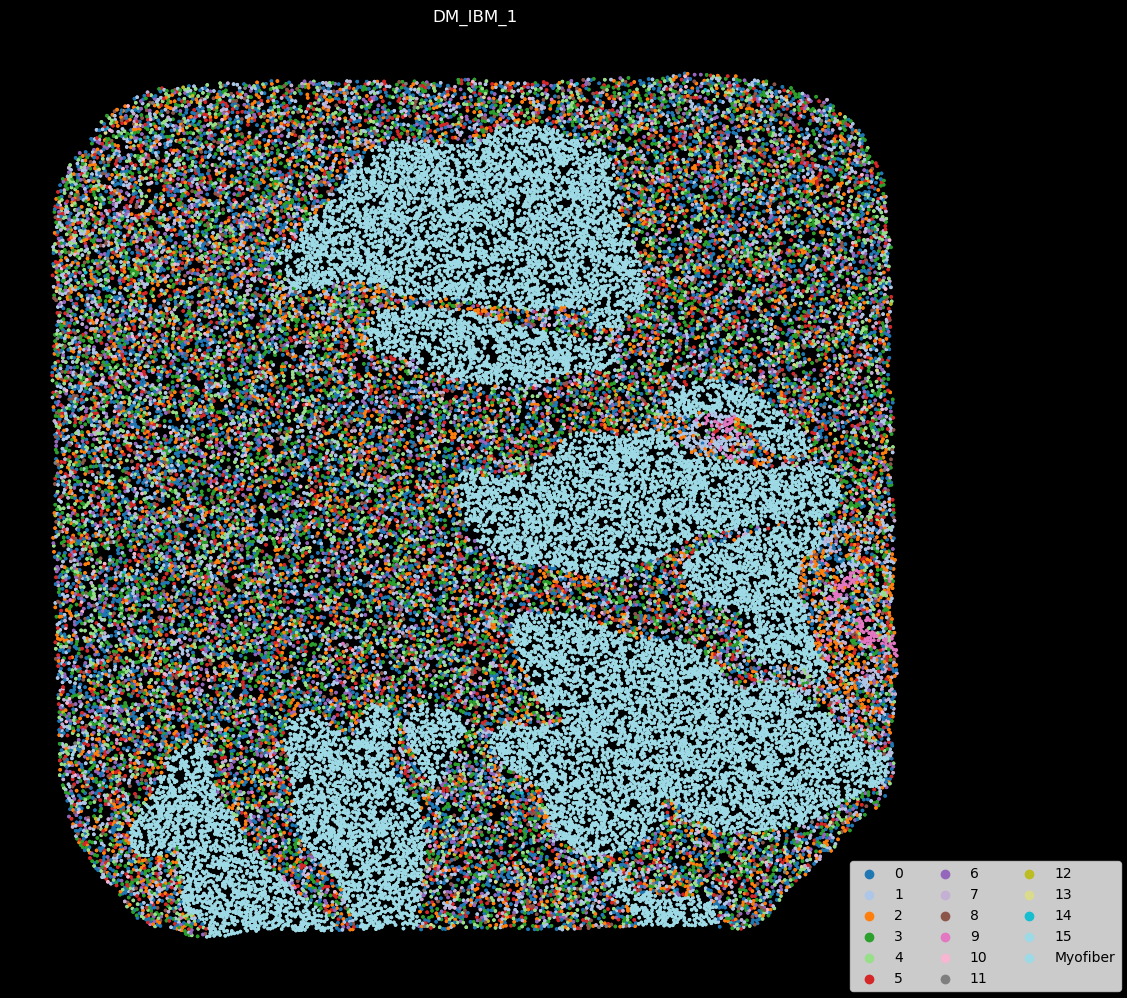

In [58]:
from datetime import datetime



fig, ax = plt.subplots(1, 1, figsize=(13,10))
sq.pl.spatial_scatter(muscle,
                      color='leiden_sel',
                      size=10,
                      shape=None,
                      ax=ax,
                      palette=newpalette)
ax.set_title('DM_IBM_1')
    
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
try:
    ax.get_legend().remove()
except:
    pass
    
fig.tight_layout()

fig.set_facecolor('k')
for text in fig.findobj(match=lambda x: isinstance(x, plt.Text)):
    if hasattr(text, 'set_color'):
        text.set_color('white')

labels_handles = {  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())    }
fig.legend( labels_handles.values(), labels_handles.keys(), loc = "lower right", ncol=3)

if SAVEFIGS:
    fig_filename = os.path.join(IMGDIR, 'DM_IBM_1_spatial_myofibers_plus_leiden' + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + '.png')
    fig.savefig(fig_filename, dpi=300)
    print('Saved figure: ' + fig_filename)
